Normal data splitting

Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9382679), ('loss', 0.27089795), ('num_examples', 88965), ('num_batches', 2785)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9783735), ('loss', 0.10112214), ('num_examples', 88965), ('num_batches', 2785)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.98302704), ('loss', 0.0801989), ('num_examples', 88965), ('num_batches', 2785)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())]))

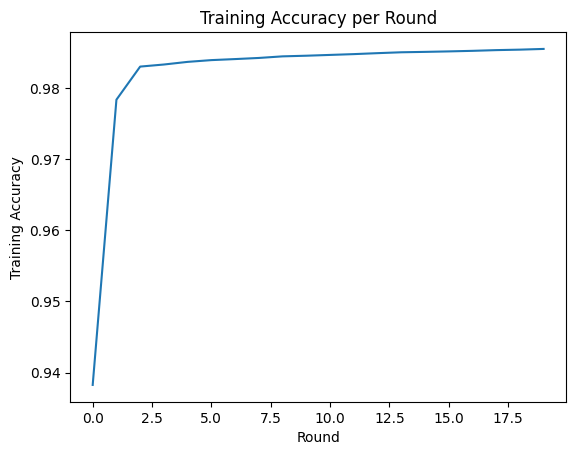

In [10]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

def preprocess(df, label_encoder=None, fit_label_encoder=True, scaler=None, fit_scaler=True):
    # Define a function to extract data within brackets or handle no bracket data
    def extract_request_type(text):
        match = re.search(r'\((.*?)\)', text)
        if match:
            return match.group(1)
        else:
            return "No specific request type"

    # Apply the function to the DataFrame
    df['REQUEST_TYPE'] = df['INFO'].apply(extract_request_type)

    # Additional feature based on interactions of Source and Destination
    df['SOURCE_DESTINATION'] = df['SOURCE'] + '_' + df['DESTINATION']

    # Encoding categorical variables
    categorical_columns = ['PROTOCOL', 'REQUEST_TYPE', 'SOURCE_DESTINATION']

    if label_encoder is None:
        # Initialize LabelEncoder for each categorical column
        label_encoder = {column: LabelEncoder() for column in categorical_columns}

    for column in categorical_columns:
        if fit_label_encoder:
            df[column] = label_encoder[column].fit_transform(df[column])
        else:
            df[column] = label_encoder[column].transform(df[column])

    # # Encode the target variable
    # if fit_label_encoder:
    #     df['TYPE_OF_ATTACK'] = label_encoder['TYPE_OF_ATTACK'].fit_transform(df['TYPE_OF_ATTACK'])
    # else:
    #     df['TYPE_OF_ATTACK'] = label_encoder['TYPE_OF_ATTACK'].transform(df['TYPE_OF_ATTACK'])

    df.drop(['NO', 'TYPE', 'INFO', 'SOURCE', 'DESTINATION'], axis=1, inplace=True)

    # Feature scaling
    if scaler is None:
        scaler = StandardScaler()

    if fit_scaler:
        df[df.columns] = scaler.fit_transform(df[df.columns])
    else:
        df[df.columns] = scaler.transform(df[df.columns])

    return df, label_encoder, scaler

def data_split_train_test(df):
    x=df.drop(['TYPE_OF_ATTACK'],axis=1)
    y=df['TYPE_OF_ATTACK']
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
    return x_train,x_test,y_train,y_test

def load_data():
    df = pd.read_csv('ECU_IoHT.csv')
    return df

df_H1=load_data()
x_train_raw,x_test_raw,y_train_raw,y_test_raw=data_split_train_test(df_H1)


#preprocess the data
processed_x_train_df,label_encoder,scaler=preprocess(x_train_raw)
processed_x_test_df, _, _ = preprocess(x_test_raw)

# Initialize a separate LabelEncoder for the target variable
target_label_encoder = LabelEncoder()
y_train_encoded = target_label_encoder.fit_transform(y_train_raw)
y_test_encoded = target_label_encoder.transform(y_test_raw)

# Combine x and y for processing - convert arrays to Series
train_df = pd.concat([processed_x_train_df, pd.Series(y_train_encoded, index=processed_x_train_df.index, name='TYPE_OF_ATTACK')], axis=1)
test_df = pd.concat([processed_x_test_df, pd.Series(y_test_encoded, index=processed_x_test_df.index, name='TYPE_OF_ATTACK')], axis=1)


# prepare data for modelling

def prepare_data_for_modeling(processed_df):
    x = processed_df.drop(['TYPE_OF_ATTACK'], axis=1)
    y = processed_df['TYPE_OF_ATTACK']
    return x, y

x_train, y_train = prepare_data_for_modeling(train_df)
x_test, y_test = prepare_data_for_modeling(test_df)

# Simulate federated data
NUM_CLIENTS = 5
client_data = []
client_data_labels = []
indices = np.arange(len(x_train))
np.random.shuffle(indices)

# Divide data among clients
client_size = len(y_train) // NUM_CLIENTS
for i in range(NUM_CLIENTS):
    start = i * client_size
    end = (i + 1) * client_size

    # Select data and labels using slicing directly on NumPy arrays
    client_data.append(x_train.iloc[start:end].to_numpy().astype(np.float32))
    client_data_labels.append(y_train[start:end])

def model_fn():
    model = Sequential([
        Dense(512, input_shape=(x_train.shape[1],), activation='relu'),
        Dense(256, activation='relu'),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])
    return model

def create_tff_model():
    keras_model = model_fn()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=(
            tf.TensorSpec(shape=[None, x_train.shape[1]], dtype=tf.float32),
            tf.TensorSpec(shape=[None], dtype=tf.int32)
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Prepare federated data
federated_data = []
for i in range(NUM_CLIENTS):
    client_ds = tf.data.Dataset.from_tensor_slices((client_data[i], tf.cast(client_data_labels[i],tf.int32))).batch(32)
    federated_data.append(client_ds)


# Initialize the federated learning process
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=create_tff_model,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

state = iterative_process.initialize()

NUM_ROUNDS = 20
train_accuracies = []
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_data)
    print(f'Round {round_num+1}, Metrics: {metrics}')
    # Extract training accuracy
    train_accuracies.append(metrics['client_work']['train']['sparse_categorical_accuracy'])

# Evaluate the global model
global_model = model_fn()
global_model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Extract weights from the TFF state and assign them to the Keras model
tff_weights = iterative_process.get_model_weights(state)
keras_weights = [np.array(w) for w in tff_weights.trainable]
global_model.set_weights(keras_weights)

# Evaluate the model on test data
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
loss, accuracy = global_model.evaluate(test_data, verbose=0)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Plotting the training accuracy
plt.plot(train_accuracies)
plt.xlabel('Round')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Round')
plt.show()



In [16]:
from sklearn.metrics import roc_curve, roc_auc_score,confusion_matrix, ConfusionMatrixDisplay

In [12]:
# Compute the ROC curve and AUC score
y_test_prob = global_model.predict(x_test.astype(np.float32))
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_train)))


696/696 [==============================] - 3s 4ms/step


In [13]:
# Calculate ROC-AUC scores and plot ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(target_label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_test_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_one_hot[:, i], y_test_prob[:, i])

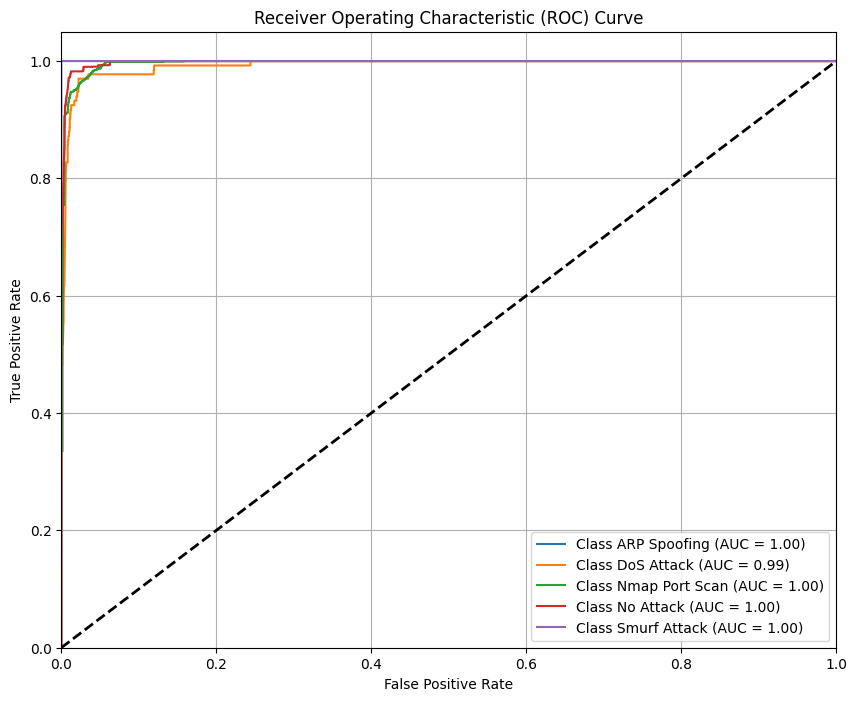

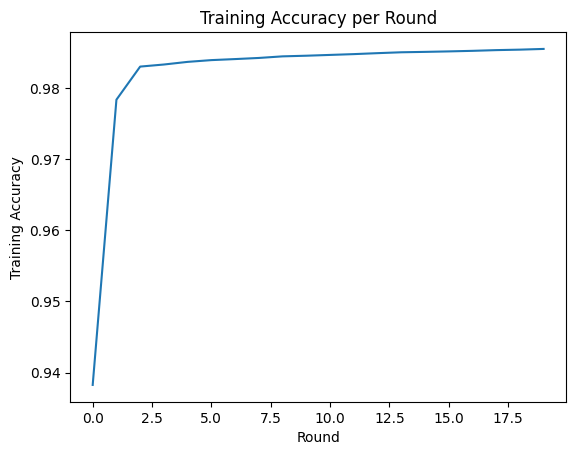

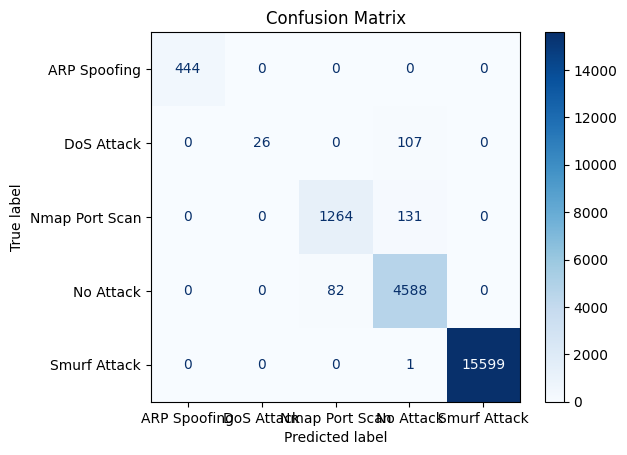

In [17]:
# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(target_label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {target_label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plotting the training accuracy
plt.plot(train_accuracies)
plt.xlabel('Round')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Round')
plt.show()

# Compute the confusion matrix
y_pred = np.argmax(y_test_prob, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()